# Insurance Purchase Prediction

Import libraries

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [223]:
df = pd.read_csv('AncillaryScoring_insurance.csv', encoding='latin-1')

In [224]:
df.head()

,PAXCOUNT,SALESCHANNEL,TRIPTYPEDESC,PURCHASELEAD,LENGTHOFSTAY,flight_hour,flight_day,ROUTE,geoNetwork_country,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,0,5.52
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,0,5.52
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,0,5.52
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,0,5.52
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,0,5.52


# Data Exploration

Check and remove missing values

In [225]:
df = df.dropna()

Check data information

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 14 columns):
PAXCOUNT               50000 non-null int64
SALESCHANNEL           50000 non-null object
TRIPTYPEDESC           50000 non-null object
PURCHASELEAD           50000 non-null int64
LENGTHOFSTAY           50000 non-null int64
flight_hour            50000 non-null int64
flight_day             50000 non-null object
ROUTE                  50000 non-null object
geoNetwork_country     50000 non-null object
BAGGAGE_CATEGORY       50000 non-null int64
SEAT_CATEGORY          50000 non-null int64
FNB_CATEGORY           50000 non-null int64
INS_FLAG               50000 non-null int64
flightDuration_hour    50000 non-null float64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.7+ MB


Plot the target variable

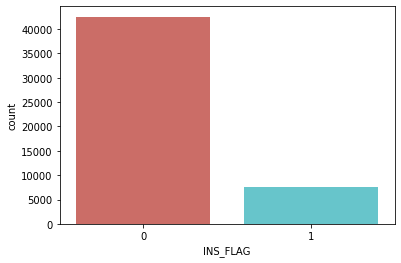

<Figure size 432x288 with 0 Axes>

In [227]:
sns.countplot(x='INS_FLAG', data = df, palette='hls')
plt.show()
plt.savefig('plot')

# Feature Engineering

Country and Route are fixed term effect so they will be dropped from our data

In [228]:
df = df.drop('ROUTE', axis = 1)
df = df.drop('geoNetwork_country', axis = 1)
#df = df.drop('flight_day', axis = 1)                          

Creating dummy variable

In [229]:
category_var = ['SALESCHANNEL', 'TRIPTYPEDESC', 'flight_day']

for var in category_var:
    category_list='var'+'_'+var
    category_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(category_list)
    df=df1

In [230]:
data_var=df.columns.values.tolist()
to_keep=[i for i in data_var if i not in category_var]

In [231]:
df_final=df[to_keep]
df_final.columns.values

array(['PAXCOUNT', 'PURCHASELEAD', 'LENGTHOFSTAY', 'flight_hour',
       'BAGGAGE_CATEGORY', 'SEAT_CATEGORY', 'FNB_CATEGORY', 'INS_FLAG',
       'flightDuration_hour', 'SALESCHANNEL_Internet',
       'SALESCHANNEL_Mobile', 'TRIPTYPEDESC_CircleTrip',
       'TRIPTYPEDESC_OneWay', 'TRIPTYPEDESC_RoundTrip', 'flight_day_Fri',
       'flight_day_Mon', 'flight_day_Sat', 'flight_day_Sun',
       'flight_day_Thu', 'flight_day_Tue', 'flight_day_Wed'], dtype=object)

In [232]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 21 columns):
PAXCOUNT                   50000 non-null int64
PURCHASELEAD               50000 non-null int64
LENGTHOFSTAY               50000 non-null int64
flight_hour                50000 non-null int64
BAGGAGE_CATEGORY           50000 non-null int64
SEAT_CATEGORY              50000 non-null int64
FNB_CATEGORY               50000 non-null int64
INS_FLAG                   50000 non-null int64
flightDuration_hour        50000 non-null float64
SALESCHANNEL_Internet      50000 non-null uint8
SALESCHANNEL_Mobile        50000 non-null uint8
TRIPTYPEDESC_CircleTrip    50000 non-null uint8
TRIPTYPEDESC_OneWay        50000 non-null uint8
TRIPTYPEDESC_RoundTrip     50000 non-null uint8
flight_day_Fri             50000 non-null uint8
flight_day_Mon             50000 non-null uint8
flight_day_Sat             50000 non-null uint8
flight_day_Sun             50000 non-null uint8
flight_day_Thu           

Our Data is highly unbalanced, so we will resample by upsampling the minority class

In [233]:
df_final_0 = df_final[df_final['INS_FLAG'] == 0]
df_final_1 = df_final[df_final['INS_FLAG'] == 1]

In [234]:
df_minority_upsampled = resample(df_final_0, 
                                 replace=True,
                                 n_samples=len(df_final_1),
                                 random_state=123)

In [235]:
df_upsampled = pd.concat([df_final_1, df_minority_upsampled])


Now, we have equal observation for both classes in the target variable

In [236]:
df_upsampled.INS_FLAG.value_counts()


1    7478
0    7478
Name: INS_FLAG, dtype: int64

# Modelling

Create the training set and test set and fix it into Logistic Regression

In [238]:
X = df_upsampled.loc[:, df_upsampled.columns != 'INS_FLAG']
y = df_upsampled.loc[:, df_upsampled.columns == 'INS_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LogisticRegression().fit(X_train, y_train)

Use the train model to get prediction on the test set

In [242]:
pred_y = clf.predict(X_test)

In [243]:
pred_y = clf.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.61


# Evaluation

confusion matrix

In [182]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred_y)
print(confusion_matrix)

[[1788 1235]
 [1120 1840]]


Classification report

In [244]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      2264
           1       0.60      0.62      0.61      2223

    accuracy                           0.61      4487
   macro avg       0.61      0.61      0.61      4487
weighted avg       0.61      0.61      0.61      4487



Plotting ROC Curve

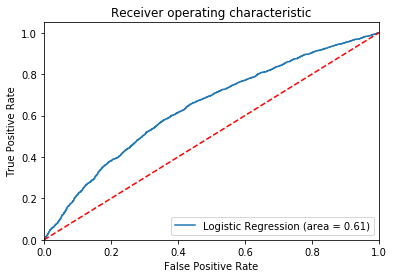

In [184]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()